In [1]:
14297/60/60

3.971388888888889

In [1]:
%pwd

'/home/zoshs2/tf_gpu/Re'

In [ ]:
##/home/zoshs2/anaconda3/envs/tf_gpu/bin/python

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import argparse
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.multiclass import type_of_target

## Multi_gpu
# from keras.utils import multi_gpu_model

In [2]:
from keras import backend as K

Using TensorFlow backend.


In [3]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Processing the training model
Train on 6930 samples, validate on 770 samples
Epoch 1/100
6930/6930 [==============================] - 22s 3ms/sample - loss: 0.1662 - mean_squared_error: 0.1662 - val_loss: 0.0859 - val_mean_squared_error: 0.0859
Epoch 2/100
6930/6930 [==============================] - 22s 3ms/sample - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 3/100
6930/6930 [==============================] - 22s 3ms/sample - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 4/100
6930/6930 [==============================] - 22s 3ms/sample - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 5/100
6930/6930 [==============================] - 22s 3ms/sample - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 6/100
6930/6930 [==============================] - 22s 3ms/sample - loss: 0.0

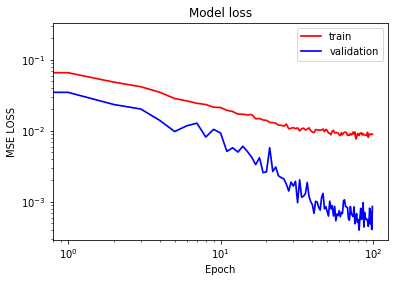

In [9]:
basepath = '/home/zoshs2/tf_gpu/Re/DATA'
Color = 'RGB'
Noise = 'WG' # WG : WHITE_GAUSSIAN_NOISE , UNI : UNIFORM_NOISE
Smoothing = 'BS2_BW1'
    
data = np.load("{}/{}_{}_{}_10318.npy".format(basepath, Smoothing, Noise, Color))

all_index = [ 3*i for i in range(67)]
np.random.shuffle(all_index)
test_index = all_index[:17]

indexes = []
for i in data['index']:
    indexes.append(i in test_index)
indexes = np.array(indexes)

test_data = data[indexes]
train_data = data[np.logical_not(indexes)]
del(data) # DON'T WASTE MEMORIES.

# np.random.seed(0)
np.random.shuffle(train_data)
np.random.shuffle(test_data)

#trainImagesX = train_data['Img'] / 255.0
# testImagesX = test_data['Img'] / 255.0
#trainY = train_data['xH'] 
# testY = test_data['xH']
#print("Done read all dataset")

# Save the test dataset for inference after training.
np.save("{}_{}_{}_TEST_DATASET".format(Smoothing, Noise, Color), test_data)
del(test_data)
# del(train_data)
#del(testImagesX)
#del(testY)

# Stratified K Fold Cross Validation for evaluation to my learning algorithm in last.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
skfscores = []
n_sample = np.zeros(train_data.shape[0])

opt = Adam(lr=1e-3, decay=1e-3/100)

for idx, (trainIDX, valIDX) in enumerate(skf.split(n_sample, n_sample)):
    fold_train_data = train_data[trainIDX]
    fold_val_data = train_data[valIDX]
    
    train_X = fold_train_data['Img'] / 255.0
    train_Y = fold_train_data['xH']
    val_X = fold_val_data['Img'] / 255.0
    val_Y = fold_val_data['xH']
    
    # Construct the learning algorithm
    
    ## CNN
    print("Processing the training model")
    model = Sequential()
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='valid', activation='relu', input_shape=(200,200,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))

    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))

    #model.add(BatchNormalization())
    #model.add(Conv2D(512, (3,3), padding='valid', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Flatten())

    ## FC
    model.add(BatchNormalization())
    #model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    #model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))

    ## Set-up the Checkpoint
    #MODEL_SAVE_FOLDER_PATH = './{}_{}/{}th_CheckPointModels/'.format(Smoothing, Color, idx)
    #if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    #    os.makedirs(MODEL_SAVE_FOLDER_PATH, exist_ok=True)

    #model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
    #checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=2,
    #                            save_best_only=True, mode='auto')
    #early_stopping = EarlyStopping(monitor='val_loss', patience = 40)
    #callbacks_list = [checkpoint, early_stopping]

    ## Compile the model & train
    model.compile(loss='MSE', optimizer=opt, metrics=['MSE'])
    hist = model.fit(train_X, train_Y, epochs=100, batch_size=12, validation_data=(val_X, val_Y)) #, callbacks=callbacks_list)

    ## Model Evaluation 
    scores = model.evaluate(val_X, val_Y, verbose=2)
    skfscores.append(scores[1])

    ## Save the history plot for fitting model and Save the final trained model
    print("Being drawing the graph of MODEL LOSS")
    plt.clf()
    plt.plot(hist.history['loss'], 'r',lw=1.7, label='train_loss')
    plt.plot(hist.history['val_loss'], 'b', lw=1.7, label='val_loss')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE LOSS')
    plt.legend(['train','validation'], loc='upper right')

    plt.savefig("{}th_{}_{}_{}_MODEL_MSELOSS.pdf".format(idx, Smoothing, Noise, Color), bbox_inches="tight", dpi=150)
    plt.savefig("{}th_{}_{}_{}_MODEL_MSELOSS.png".format(idx, Smoothing, Noise, Color), bbox_inches="tight", dpi=150)

    model.save("{}th_{}_{}_{}_FinalModel_MSE.hdf5".format(idx, Smoothing, Noise, Color))

## Record the evaluation scores for each k-fold. 
### Could look whether my own model has been likely to be overfitted for ONLY train data.
    line = "{0}_th ::: LOSS = {1:0.5f}, MSE = {2:0.5f} \n".format(idx, scores[0], scores[1])
    with open("{}_{}_{}_skfscores.txt".format(Smoothing, Noise, Color), 'a') as f:
        f.write(line)
    
skfscores_mean = np.mean(skfscores)
skfscores_std = np.std(skfscores)

line = "RESULT ::: K-fold Score :: MEAN = {0:0.5f}, STD = {1:0.5f}".format(skfscores_mean, skfscores_std)
with open("{}_{}_{}_SKFscores.txt".format(Smoothing, Noise, Color), 'a') as f:
        f.write(line)

In [4]:
tf.keras.metrics.RootMeanSquaredError

tensorflow.python.keras.metrics.RootMeanSquaredError

In [1]:
import numpy as np

In [26]:
a = np.random.rand(200)

In [27]:
a

array([0.03999675, 0.66067757, 0.21898756, 0.81012305, 0.3395215 ,
       0.87852608, 0.70088245, 0.51682271, 0.09365355, 0.87635746,
       0.97043745, 0.57075078, 0.2625942 , 0.22128974, 0.04236181,
       0.82606748, 0.54833277, 0.5286269 , 0.96562852, 0.56491318,
       0.98439294, 0.76393652, 0.17028953, 0.95788545, 0.89782098,
       0.95763062, 0.85413613, 0.46021551, 0.37223263, 0.34747886,
       0.14216429, 0.94206766, 0.23041958, 0.04471022, 0.69667847,
       0.8692304 , 0.48237567, 0.76052805, 0.12441604, 0.51237805,
       0.31732401, 0.81661086, 0.17450462, 0.89776533, 0.37483794,
       0.35544033, 0.64349172, 0.1620614 , 0.15835249, 0.56313686,
       0.53140295, 0.3521463 , 0.86753109, 0.91641438, 0.11713368,
       0.241401  , 0.35590396, 0.53787636, 0.24812291, 0.98917283,
       0.88298828, 0.87245518, 0.66200847, 0.92461877, 0.13819731,
       0.91348452, 0.21107505, 0.67929156, 0.27689778, 0.29325246,
       0.46893117, 0.22152198, 0.22952478, 0.28315084, 0.18186

In [28]:
a.shape

(200,)

In [29]:
b = np.arange(200)

In [30]:
b.shape

(200,)

In [31]:
import matplotlib.pyplot as plt

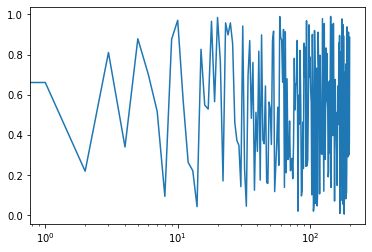

In [34]:
plt.plot(b, a)
plt.xscale('log')
plt.show()

In [35]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 이 시점에서 표현(representatoin)은 (4,4,8) 즉, 128 차원

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.
W0923 21:37:46.497441 139958596888384 deprecation_wrapper.py:119] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 21:37:46.526731 139958596888384 deprecation_wrapper.py:119] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 21:37:46.531587 139958596888384 deprecation_wrapper.py:119] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 21:37:46.552248 139958596888384 deprecation_wrapper.py:119] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name t

In [58]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

In [59]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용

In [43]:
x_train[0].shape

(28, 28)

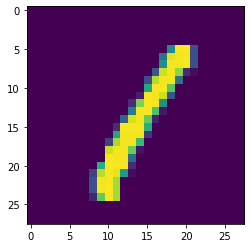

In [47]:
plt.imshow(x_train[3])
plt.show()

In [61]:
from multiprocessing import Process

In [63]:
import numpy as np

In [1]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
BatchNormalization()

In [ ]:
TensorBoard()

In [113]:
np.random.randint(1,4)

3

In [62]:
__name__

'__main__'

In [60]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/home/zoshs2/tf_gpu/Re/tensorboard_log/')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.0967 - val_loss: 0.0941
Epoch 2/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.0967 - val_loss: 0.0969
Epoch 3/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.0967 - val_loss: 0.0953
Epoch 4/50
60000/60000 [==============================] - 5s 81us/step - loss: 0.0965 - val_loss: 0.1003
Epoch 5/50
60000/60000 [==============================] - 5s 81us/step - loss: 0.0965 - val_loss: 0.0965
Epoch 6/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.0964 - val_loss: 0.0958
Epoch 7/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.0964 - val_loss: 0.0946
Epoch 8/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.0962 - val_loss: 0.0943
Epoch 9/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0962 - val_loss: 0.0951
Epoch

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from mpl_toolkits.mplot3d import axes3d

In [4]:
bs_point = np.array([1, 1, 1, 2, 2, 2, 3, 3, 3])
bw_point = np.array([0.2, 1, 2, 0.2, 1, 2, 0.2, 1, 2])

In [5]:
loss_point = np.array([0.00035, 0.00044, 0.00061, 0.00030, 0.00045, 0.00043, 0.00067, 0.00032, 0.00046])

In [39]:
print((0.00035 + 0.00030+0.00067)/3)
print((0.00032 + 0.00045)/2)
print((0.00046 + 0.00043 + 0.00061) / 3)


0.000325
0.00038500000000000003
0.0005


In [54]:
x = np.arange(10)
y = np.array(range(10,15))
data_value = np.random.rand(len(y), len(x))

In [56]:
x.shape

(10,)

In [57]:
y.shape

(5,)

In [55]:
data_value.shape

(5, 10)

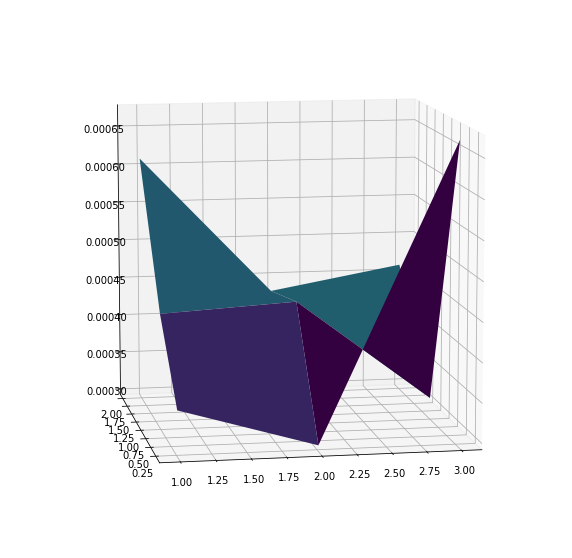

In [157]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

# as plot_surface needs 2D arrays as input
x = np.arange(1,4)
y = np.array([0.2,1,2])
X,Y = np.meshgrid(x,y)
Z = np.array([[0.00035, 0.00030, 0.00067], 
             [0.00044, 0.00045, 0.00032],[0.00061, 0.00043, 0.00046]])

colors = cm.ScalarMappable(cmap = "viridis").to_rgba(Z)
# plot_surface with points X,Y,Z and data_value as colors
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=colors, linewidth=0, antialiased=True)
ax.view_init(elev=10, azim=260)

plt.show()

In [140]:
loss_point

array([0.00035, 0.00044, 0.00061, 0.0003 , 0.00045, 0.00043, 0.00067,
       0.00032, 0.00046])

In [176]:
def distance_2d(x_point, y_point, x, y):
    return np.hypot(x-x_point, y-y_point)

In [177]:
ys, xs = np.ogrid[-5:5, -5:5]
distances = distance_2d(1, 2, xs, ys)

In [178]:
distances.shape

(10, 10)

In [180]:
ys.shape

(10, 1)

In [179]:
xs.shape

(1, 10)

In [181]:
ys, xs = np.ogrid[1:3:200j, 0.2:2:200j]

In [182]:
ys.shape

(200, 1)

In [183]:
xs.shape

(1, 200)

In [184]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
vals = np.reshape(A, (9))

In [187]:
vals = np.reshape(Z, (9))

In [192]:
vals

array([0.00035, 0.0003 , 0.00067, 0.00044, 0.00045, 0.00032, 0.00061,
       0.00043, 0.00046])

In [215]:
pts = np.array([[i,j] for i in np.linspace(0.2,2,3) for j in np.linspace(1,3,3)] )
grid_x, grid_y = np.mgrid[0.2:2:200j], np.mgrid[1:3:200j]

In [217]:
grid_x.shape

(200,)

In [193]:
import scipy.interpolate as inter
grid_z = inter.griddatan(pts, vals, (grid_x, grid_y), method='linear')

In [194]:
grid_z

array([[0.00035   , 0.0003495 , 0.00034899, ..., 0.00066256, 0.00066628,
        0.00067   ],
       [0.0003509 , 0.0003504 , 0.0003499 , ..., 0.00065905, 0.00066276,
        0.00066648],
       [0.00035181, 0.00035131, 0.0003508 , ..., 0.00065553, 0.00065925,
        0.00066296],
       ...,
       [0.00060658, 0.00060477, 0.00060296, ..., 0.00045658, 0.00045688,
        0.00045719],
       [0.00060829, 0.00060648, 0.00060467, ..., 0.00045799, 0.00045829,
        0.00045859],
       [0.00061   , 0.00060819, 0.00060638, ..., 0.0004594 , 0.0004597 ,
        0.00046   ]])

In [214]:
grid_x.ravel().shape

(40000,)

In [212]:
grid_y.ravel().shape

(40000,)

In [203]:
grid_x.ravel()

array([0.2, 0.2, 0.2, ..., 2. , 2. , 2. ])

In [196]:
grid_x.shape

(200, 200)

In [197]:
grid_y.shape

(200, 200)

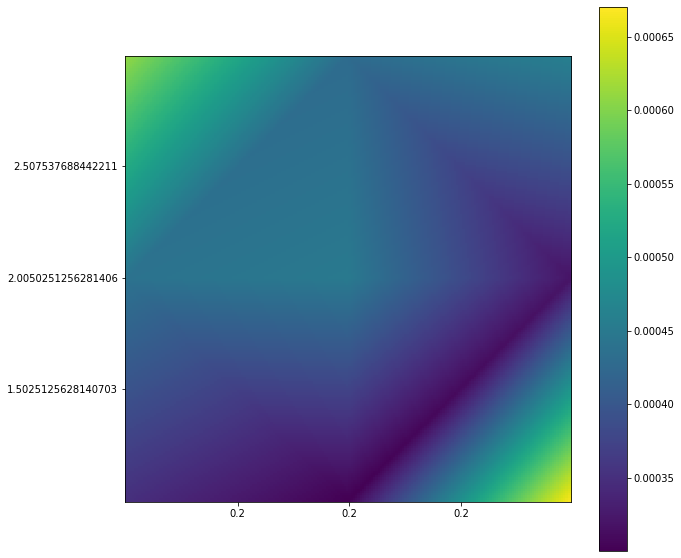

In [207]:
plt.figure(figsize=(10,10))
plt.imshow(grid_z, origin='lower', interpolation="none")
plt.xticks(np.arange(grid_x.shape[1])[[50,100,150]], grid_x.ravel()[[50,100,150]])  # need to set the ticks manually
plt.yticks(np.arange(grid_y.shape[0])[[50,100,150]], grid_y.ravel()[[50,100,150]])
#plt.axis('off')
plt.colorbar()
plt.show()

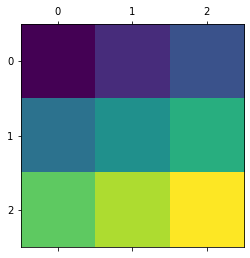

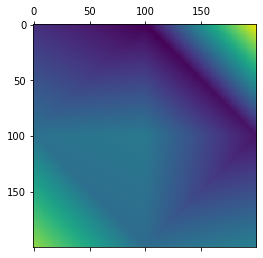

In [195]:
plt.matshow(A)
plt.matshow(grid_z)
plt.show()

In [189]:
pts = np.array([[i,j] for i in [0.0, 0.5, 1.0] for j in [0.0, 0.5, 1.0]] )

In [190]:
pts

array([[0. , 0. ],
       [0. , 0.5],
       [0. , 1. ],
       [0.5, 0. ],
       [0.5, 0.5],
       [0.5, 1. ],
       [1. , 0. ],
       [1. , 0.5],
       [1. , 1. ]])

In [ ]:
pts = np.array([[i,j] for i in np.linspace(0.2,2,3) for j in np.linspace(1,3,3)] )
grid_x, grid_y = np.mgrid[0.2:2:200j, 1:3:200j]

In [ ]:
plt.figure()
plt.title('distance to point (1, 2)')
plt.imshow(distances, origin='lower', interpolation="none")
plt.xticks(np.arange(xs.shape[1]), xs.ravel())  # need to set the ticks manually
plt.yticks(np.arange(ys.shape[0]), ys.ravel())
plt.colorbar()

In [175]:
ys.shape[0]

200

In [174]:
xs.shape[1]

200

In [162]:
xs[0]

array([1.])

In [161]:
xs[-1]

array([3.])

In [138]:
X

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [139]:
Y

array([[0.2, 0.2, 0.2],
       [1. , 1. , 1. ],
       [2. , 2. , 2. ]])

In [137]:
Z

array([[0.00035, 0.0003 , 0.00067],
       [0.00044, 0.00045, 0.00032],
       [0.00061, 0.00043, 0.00046]])

In [39]:
x

array([1, 2, 3])

In [40]:
y

array([0.2, 1. , 2. ])

In [41]:
X,Y = np.meshgrid(x,y)

In [42]:
print(X)
print(Y)

[[1 2 3]
 [1 2 3]
 [1 2 3]]
[[0.2 0.2 0.2]
 [1.  1.  1. ]
 [2.  2.  2. ]]


In [26]:
# as plot_surface needs 2D arrays as input
x = np.arange(10)
y = np.array(range(10,15))
# we make a meshgrid from the x,y data
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

In [6]:
import numpy as np

In [8]:
bw_point = np.array([0.2,1,2])

In [9]:
bs_point = np.array([1,2,3,6])

In [10]:
loss_point = np.array([0.00035, 0.00030, 0.00067, 0.00087, 0.00044, 0.00045, 0.00032, 0.00061, 0.00061, 0.00043, 0.00046, 0.00056])

In [17]:
bs_point1 = np.array([6,6,6])
bw_point1 = np.array([0.2,1,2])
sw1 = (bs_point1/bw_point1)
print(sw1)

[30.  6.  3.]


In [16]:
loss_point1 = np.array([0.00087,0.00061, 0.00056])

In [11]:
sw_ratio = (bs_point/bw_point.reshape(1,-1).T).reshape(-1)

In [17]:
(bw_point/bs_point.reshape(1,-1))

array([[0.2       , 0.5       , 0.66666667]])

In [219]:
loss_point = np.array([0.00035, 0.00044, 0.00061, 0.00030, 0.00045, 0.00043, 0.00067, 0.00032, 0.00046])

In [25]:
bw_point

array([0.2, 1. , 2. ])

In [29]:
bs_point.reshape(1,-1).T

array([[1],
       [2],
       [3]])

In [30]:
bw_point/(bs_point.reshape(1,-1).T)

array([[0.2       , 1.        , 2.        ],
       [0.1       , 0.5       , 1.        ],
       [0.06666667, 0.33333333, 0.66666667]])

In [24]:
(bw_point/bs_point.reshape(1,-1).T)

array([[0.2       , 1.        , 2.        ],
       [0.1       , 0.5       , 1.        ],
       [0.06666667, 0.33333333, 0.66666667]])

In [33]:
(bw_point/bs_point.reshape(1,-1).T).reshape(-1)

array([0.2       , 1.        , 2.        , 0.1       , 0.5       ,
       1.        , 0.06666667, 0.33333333, 0.66666667, 0.03333333,
       0.16666667, 0.33333333])

In [229]:
ws = (bw_point/bs_point.reshape(1,-1).T).reshape(-1)

In [231]:
ws

array([0.2       , 1.        , 2.        , 0.1       , 0.5       ,
       1.        , 0.06666667, 0.33333333, 0.66666667])

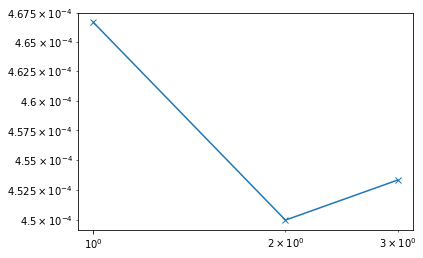

In [222]:
plt.loglog(bs_point[::3], [np.average(loss_point[i:i+3]) for i in range(3)],'x-')
plt.show()

In [296]:
np.arange(2)

array([0, 1])

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

In [5]:
## This code comes from sliceplot.py of 21cmFAST
################################################

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [6]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['yellow','red','black','green','blue'])
norm = MidpointNormalize(midpoint=0)

In [19]:
BS1_BW02 = np.load("DATA/BS1_BW02_WG_RGB_10318.npy")

In [20]:
BS1_BW02['z'][1940]

12.73

In [21]:
BS1_BW02['xH'][1940]

0.9760636687278748

<Figure size 432x288 with 0 Axes>

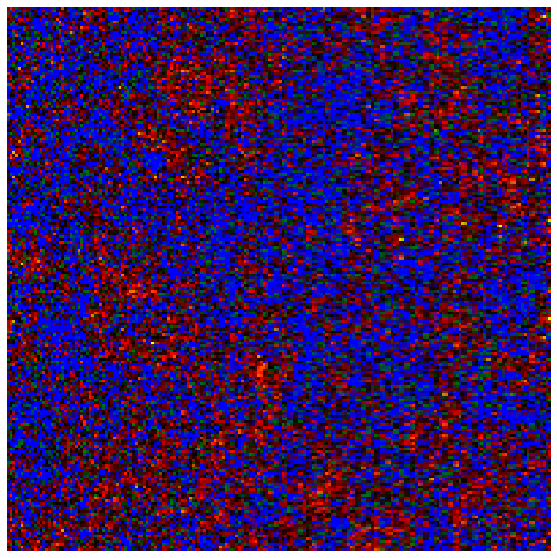

0.9760636687278748


In [12]:
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(BS1_BW02['Img'][1940], cmap=cmap, norm=norm)
plt.clim(vmin=-210, vmax=30)
plt.axis("off")

plt.savefig("POSTER_0.976_BS1_BW02_1940.png", bbox_inches='tight', pad_inches=0)
plt.show()
print(BS1_BW02['xH'][1940])

In [13]:
w1 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
s1 = np.array([1, 3, 6, 24, 48])

In [14]:
sw_ratio1 = s1/w1

In [15]:
sw_ratio1

array([  5.,  15.,  30., 120., 240.])

In [16]:
loss_point1 = np.array([0.00062, 0.00198, 0.00552, 0.03332, 0.05166])

In [17]:
w2 = np.array([1, 1, 1, 1, 1, 1, 1])
s2 = np.array([1, 2, 3, 6, 12, 24, 48])
sw_ratio2 = s2/w2
loss_point2 = np.array([0.00113, 0.00046, 0.00068, 0.00148, 0.00710, 0.02927, 0.05491])

In [18]:
w3 = np.array([2, 2, 2, 2, 2, 2, 2])
s3 = np.array([1, 2, 3, 6, 12, 24, 48])
sw_ratio3 = s3/w3
loss_point3 = np.array([0.00075, 0.00115, 0.00089, 0.00471, 0.00294, 0.02320, 0.05236])

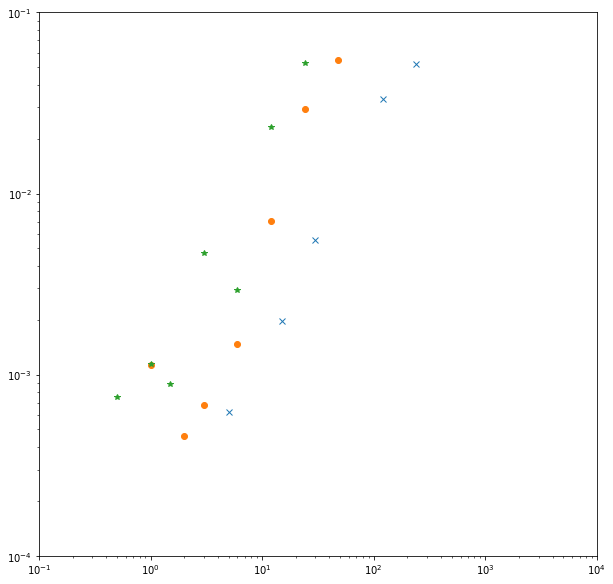

In [21]:
plt.figure(figsize=(10,10))
plt.loglog(sw_ratio1, loss_point1, 'x')
plt.loglog(sw_ratio2, loss_point2, 'o')
plt.loglog(sw_ratio3, loss_point3, '*')
plt.xlim([0.1,10000])
plt.ylim([1e-4,1e-1])
plt.show()

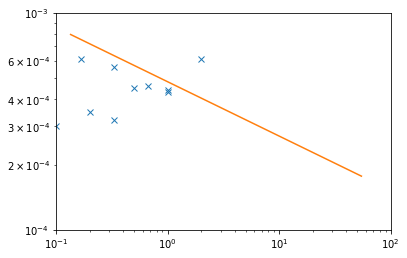

In [20]:
plt.loglog(1/sw_ratio, loss_point,'x')
plt.loglog(np.exp(6*np.arange(2)-2),np.exp(-1.5*(np.arange(2))-7.14))
plt.xlim([0.1,100])
plt.ylim([1e-4,1e-3])
plt.show()

In [300]:
a = np.arange(100)

In [301]:
b = 1/2*(a*a)

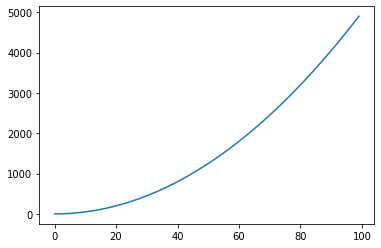

In [299]:
plt.plot(a,b)
plt.show()

In [ ]:
np.arange(10)

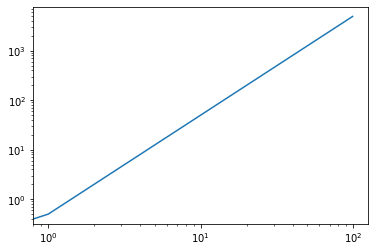

In [302]:
plt.loglog(a, b)
plt.show()

In [13]:
import matplotlib.pyplot as plt

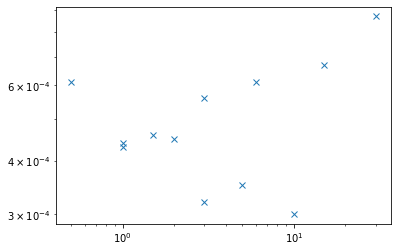

In [15]:
plt.loglog(sw_ratio, loss_point,'x')
# plt.loglog(np.exp(6*np.arange(2)-3),np.exp(1.5*(np.arange(2))-8.44))
#plt.xlim([0.1,100])
#plt.ylim([1e-4,1e-3])
plt.show()

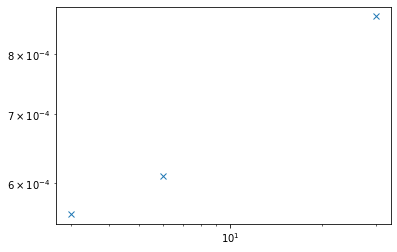

In [18]:
plt.loglog(sw1, loss_point1,'x')
# plt.loglog(np.exp(6*np.arange(2)-3),np.exp(1.5*(np.arange(2))-8.44))
#plt.xlim([0.1,100])
#plt.ylim([1e-4,1e-3])
plt.show()

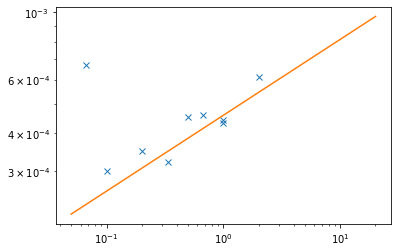

In [295]:
plt.loglog(ws, loss_point,'x')
plt.loglog(np.exp(6*np.arange(2)-3),np.exp(1.5*(np.arange(2))-8.44))
#plt.xlim([0.1,100])
#plt.ylim([1e-4,1e-3])
plt.show()

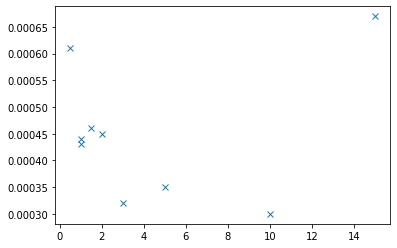

In [234]:
plt.plot(1/ws, loss_point,'x')
plt.show()

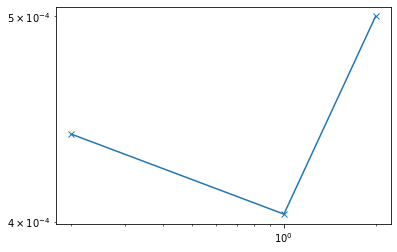

In [225]:
plt.loglog(bw_point, [np.average(loss_point[i::3]) for i in range(3)],'x-')
plt.show()

In [46]:
Z = np.array([[0.00035, 0.00030, 0.00067], 
             [0.00044, 0.00045, 0.00032],[0.00061, 0.00043, 0.00046]])

In [48]:
X.shape

(3, 3)

In [49]:
Y.shape

(3, 3)

In [50]:
Z.shape

(3, 3)

In [37]:
# we make a meshgrid from the x,y data
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

In [51]:
# data_value shall be represented by color
# data_value = np.random.rand(len(y), len(x))
# map the data to rgba values from a colormap
# colors = cm.ScalarMappable(cmap = "viridis").to_rgba(data_value)


# plot_surface with points X,Y,Z and data_value as colors
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)

plt.show()

In [34]:
(0.00035 + 0.00061) / 2

0.00047999999999999996

In [35]:
(0.00030+0.00045+0.00043) / 3

0.00039333333333333337

In [36]:
(0.00032+0.00046) / 2

0.00039000000000000005

In [37]:
bs1_point = np.array([1,2,3])
loss1_point = np.array([0.0004799, 0.0003933, 0.00039])

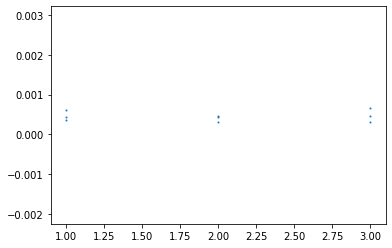

In [16]:
plt.scatter(bs_point, loss_point, s=1)
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [40]:
bw1_point = np.array([0.2, 1, 2])
loss2_point = np.array([0.000325, 0.000385, 0.0005])

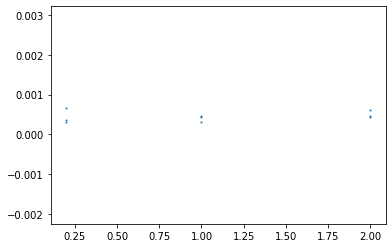

In [15]:
plt.scatter(bw_point, loss_point, s=1)
#plt.yscale('log')
#plt.xscale('log')
plt.show()

/home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  after removing the cwd from sys.path.
/home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


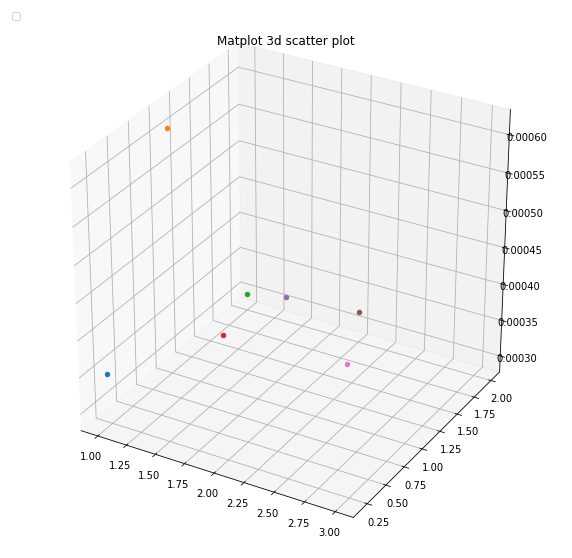

In [17]:
# Create plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)# , axisbg="1.0")
ax = fig.gca(projection='3d')

for data in zip(bs_point, bw_point, loss_point):
    x, y, z = data
    ax.scatter(x, y, z)

plt.title('Matplot 3d scatter plot')
plt.legend(loc=2)
plt.show()


# 트레이닝된 Model Inference(test) 실시 

In [1]:
from tensorflow.keras.models import load_model
import numpy as np

In [2]:
import h5py

In [3]:
import matplotlib as mpl

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
%pwd

'/home/zoshs2/tf_gpu/Re'

In [11]:
BS1_BW02 = np.load("./DATA/BS1_BW02_NN_RGB_10318.npy")

In [31]:
BS1_BW02_sep = BS1_BW02[(BS1_BW02['Box'] == 300)]

In [32]:
BS1_BW02_sep1 = BS1_BW02_sep[(BS1_BW02_sep['z'] == 6.58)]

In [33]:
the3 = BS1_BW02_sep1[(BS1_BW02_sep1['index'] == 165)]

In [23]:
the1.dtype

dtype([('Img', '<i8', (200, 200, 3)), ('xH', '<f8'), ('Box', '<i8'), ('z', '<f8'), ('index', '<i8')])

In [22]:
the1.shape

(1,)

<Figure size 432x288 with 0 Axes>

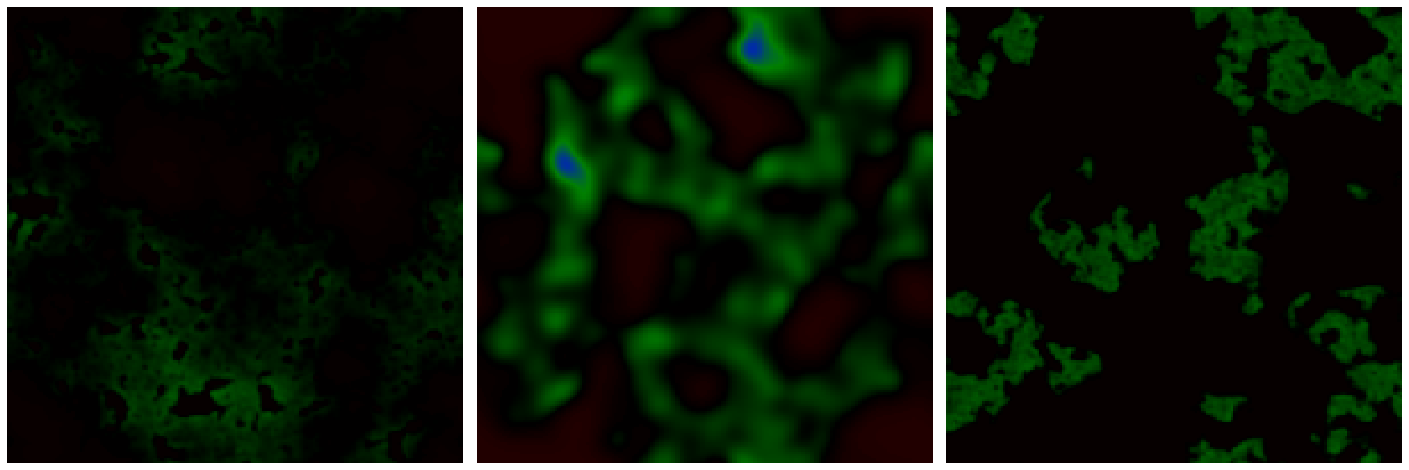

In [36]:
plt.clf()
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(the1['Img'][0])
# print("first :", round(testY[1000], 3))
plt.axis('off')
# plt.text(5, 190, r"$\widebar{x}_{HI, true} = 0.841$" "\n" r"$\widebar{x}_{HI, pred} = 0.829$", color='black', style='italic', fontsize=20, fontweight='bold', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})

plt.subplot(132)
plt.imshow(the2['Img'][0])
#print("second :", round(testY[100],3))
plt.axis('off')
#plt.text(5, 190, r"$\widebar{x}_{HI, true} = 0.673$" "\n" r"$\widebar{x}_{HI, pred} = 0.701$", color='black', style='italic', fontsize=20, fontweight='bold', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})

plt.subplot(133)
plt.imshow(the3['Img'][0])
#print("third :", round(testY[700], 3))
plt.axis('off')
#plt.text(5, 190, r"$\widebar{x}_{HI, true} = 0.168$" "\n" r"$\widebar{x}_{HI, pred} = 0.159$", color='black', style='italic', fontsize=20, fontweight='bold', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 8})

plt.subplots_adjust(wspace=0.03)
#plt.savefig("THESIS_EXTREMELY_NOISED_with_BS1_BW02_1000h", bbox_inches='tight')
plt.show()

# THESIS_ Severe Noising to Image ( Beamsize 1 arcmin and Bandwidth 0.2 MHz )

In [12]:
test_data = np.load("/home/zoshs2/tf_gpu/Re/BS1_BW02_RGB/BS1_BW02_WG_RGB_TEST_DATASET.npy")
testY = test_data['xH']
testImageX = test_data['Img'] / 255.0

In [13]:
test_data.dtype

dtype([('Img', '<i8', (200, 200, 3)), ('xH', '<f8'), ('Box', '<i8'), ('z', '<f8'), ('index', '<i8'), ('xH_cat', '<i4')])

In [7]:
print(test_data['xH'][700])

0.16827672719955444


In [38]:
print(test_data['Box'][100])
print(test_data['z'][100])
print(test_data['index'][100])

50
8.42
192


first : 0.841
second : 0.673
third : 0.168


<Figure size 432x288 with 0 Axes>

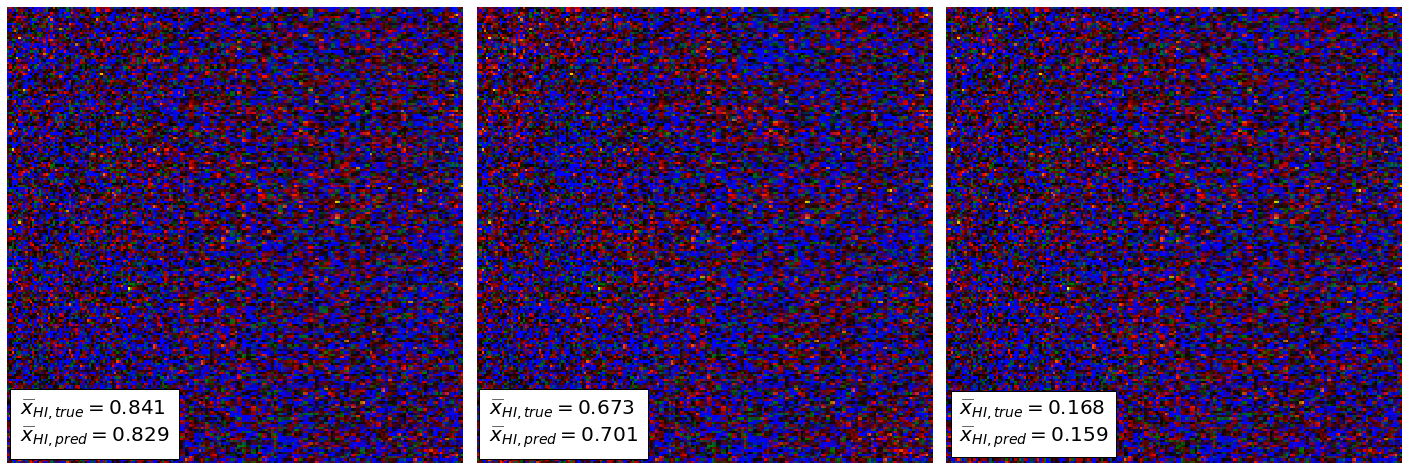

In [14]:
plt.clf()
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(testImageX[1000])
print("first :", round(testY[1000], 3))
plt.axis('off')
plt.text(5, 190, r"$\widebar{x}_{HI, true} = 0.841$" "\n" r"$\widebar{x}_{HI, pred} = 0.829$", color='black', style='italic', fontsize=20, fontweight='bold', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})

plt.subplot(132)
plt.imshow(testImageX[100])
print("second :", round(testY[100],3))
plt.axis('off')
plt.text(5, 190, r"$\widebar{x}_{HI, true} = 0.673$" "\n" r"$\widebar{x}_{HI, pred} = 0.701$", color='black', style='italic', fontsize=20, fontweight='bold', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})

plt.subplot(133)
plt.imshow(testImageX[700])
print("third :", round(testY[700], 3))
plt.axis('off')
plt.text(5, 190, r"$\widebar{x}_{HI, true} = 0.168$" "\n" r"$\widebar{x}_{HI, pred} = 0.159$", color='black', style='italic', fontsize=20, fontweight='bold', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 8})

plt.subplots_adjust(wspace=0.03)
plt.savefig("THESIS_EXTREMELY_NOISED_with_BS1_BW02_1000h.pdf", bbox_inches='tight', dpi=600)
plt.show()

In [16]:
model = load_model("/home/zoshs2/tf_gpu/Re/BS1_BW02_RGB/1th_CheckPointModels/77-0.0002.hdf5")

W1204 23:30:10.048790 140415139030848 deprecation.py:506] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1204 23:30:10.050448 140415139030848 deprecation.py:506] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1204 23:30:10.051717 140415139030848 deprecation.py:506] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97

In [17]:
testOutput = model.predict(testImageX)#, batch_size=3)
testOutput = np.squeeze(testOutput, axis=1)

In [89]:
testOutput.shape

(2064,)

In [85]:
np.mean(testOutput)

0.6054553

In [86]:
np.std(testOutput)

0.30630112

In [87]:
np.mean(testY)

0.6065305610318442

In [88]:
np.std(testY)

0.3086614514546581

In [90]:
binlist = np.arange(0, 1.05, 0.05)

In [91]:
binlist

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

<Figure size 432x288 with 0 Axes>

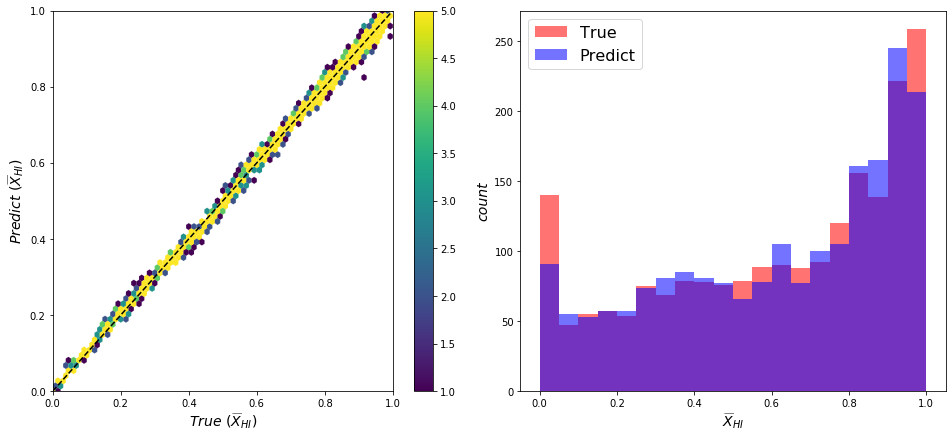

In [118]:
plt.clf()
fig, axs = plt.subplots(1,2, figsize=(16,7))
hexaxs, histoaxs = axs[0], axs[1]
hexplot = hexaxs.hexbin(testY, testOutput, gridsize=65, extent=(0,1,0,1), cmap='viridis', mincnt=1, linewidths=(0.1,))
hexaxs.plot([0,1],[0,1], 'k--', lw=1.5)
hexaxs.set_xlabel("True $(\widebar{X}_{HI})$", style='italic',fontsize=14)
hexaxs.set_ylabel("Predict $(\widebar{X}_{HI})$", style='italic',fontsize=14)

histoaxs.hist(testY, bins=binlist, color='Red',label='true', alpha=0.55)
histoaxs.hist(testOutput, bins=binlist, color='Blue', label='predict', alpha=0.55)
histoaxs.set_xlabel("$\widebar{X}_{HI}$", style='italic', fontsize=14)
histoaxs.set_ylabel("count", style='italic', fontsize=14)
plt.legend(['True','Predict'], loc='upper left',prop={'size': 16})
plt.colorbar(hexplot,ax=hexaxs)
hexplot.set_clim(vmin=1, vmax=5)
fig.subplots_adjust(wspace=0.1)
# plt.savefig("POSTER_BS1_BW02_HISto&hexbin_1000h.png", bbox_inches='tight', pad_inches=0)
plt.show()

# THESIS_ Severe Coarsing to Image ( Beamsize 3 arcmin and Bandwidth 2 MHz )

In [15]:
test_data = np.load("/home/zoshs2/tf_gpu/Re/BS3_BW2_RGB/BS3_BW2_WG_RGB_TEST_DATASET.npy")
testY = test_data['xH']
testImageX = test_data['Img'] / 255.0

In [16]:
test_data.dtype

dtype([('Img', '<i8', (200, 200, 3)), ('xH', '<f8'), ('Box', '<i8'), ('z', '<f8'), ('index', '<i8'), ('xH_cat', '<i4')])

first : 0.952
second : 0.55
third : 0.261


<Figure size 432x288 with 0 Axes>

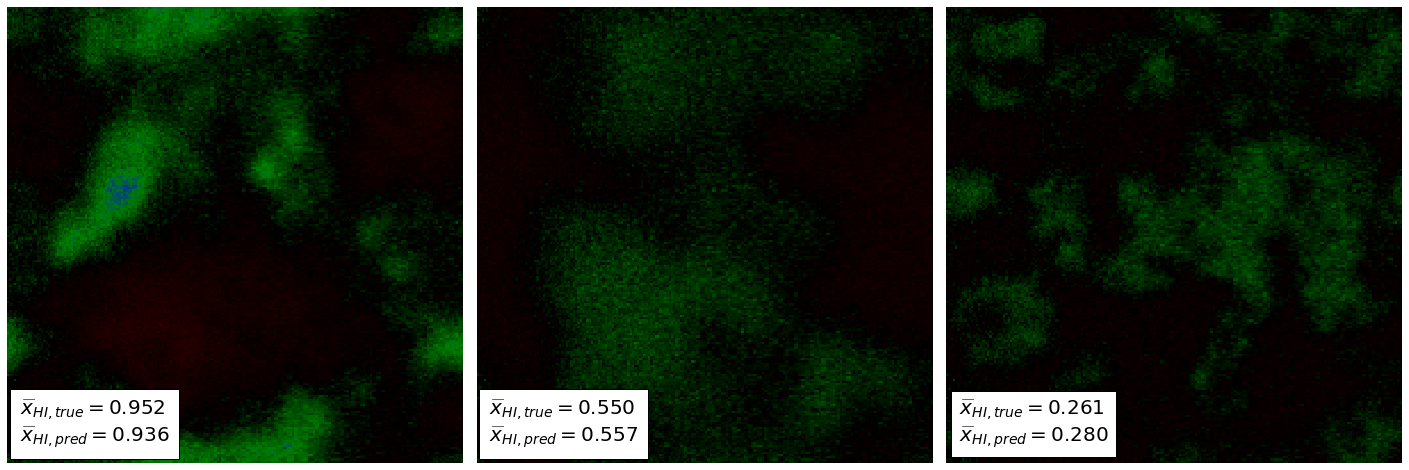

In [17]:
plt.clf()
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.imshow(testImageX[30])
print("first :", round(testY[30], 3))
plt.axis('off')
plt.text(5, 190, r"$\widebar{x}_{HI, true} = 0.952$" "\n" r"$\widebar{x}_{HI, pred} = 0.936$", color='black', style='italic', fontsize=20, fontweight='bold', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})

plt.subplot(132)
plt.imshow(testImageX[1542])
print("second :", round(testY[1542],3))
plt.axis('off')
plt.text(5, 190, r"$\widebar{x}_{HI, true} = 0.550$" "\n" r"$\widebar{x}_{HI, pred} = 0.557$", color='black', style='italic', fontsize=20, fontweight='bold', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})

plt.subplot(133)
plt.imshow(testImageX[740])
print("third :", round(testY[740], 3))
plt.axis('off')
plt.text(5, 190, r"$\widebar{x}_{HI, true} = 0.261$" "\n" r"$\widebar{x}_{HI, pred} = 0.280$", color='black', style='italic', fontsize=20, fontweight='bold', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 8})

plt.subplots_adjust(wspace=0.03)
plt.savefig("THESIS_EXTREMELY_COARSED_with_BS3_BW2_1000h.pdf", bbox_inches='tight', dpi=600)
plt.show()

# 내가 논문에 어떤 체크포인트웨이트들을 사용했는지? (LOSS)
BS1_BW02 : 2th_loss  
BS1_BW1 : 2th_loss  
BS1_BW2 : 1th_loss  
  
BS2_BW02 : 4th_loss  
BS2_BW1 : 4th_loss  
BS2_BW2 : 3th_loss  
  
BS3_BW02 : 0th_loss  
BS3_BW1 : 3th_loss  
BS3_BW2 : 4th_loss  
  
# 히스토그램과 헥스빈에 사용한 trained model
BS1_BW02 : 1th / 77-0.0002.hdf5   
BS1_BW1 : 1th / 87-0.0002.hdf5  
BS1_BW2 : 3th / 161-0.0003.hdf5

BS2_BW02 : 1th / 84-0.0002.hdf5  
BS2_BW1 : 0th / 192-0.0002.hdf5   
BS2_BW2 : 0th / 123-0.0002.hdf5  
  
BS3_BW02 : 4th / 92-0.0003.hdf5  
BS3_BW1 : 0th / 156-0.0001.hdf5  
BS3_BW2 : 0th / 199-0.0002.hdf5

In [1]:
from tensorflow.keras.models import load_model
import numpy as np

In [2]:
import h5py

In [3]:
import matplotlib as mpl

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
model = load_model("/home/zoshs2/tf_gpu/Re/BS3_BW2_RGB/0th_CheckPointModels/199-0.0002.hdf5")

W0316 19:07:11.052158 140099106625344 deprecation.py:506] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0316 19:07:11.053611 140099106625344 deprecation.py:506] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0316 19:07:11.055033 140099106625344 deprecation.py:506] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97

In [6]:
test_data = np.load("/home/zoshs2/tf_gpu/Re/BS3_BW2_RGB/BS3_BW2_WG_RGB_TEST_DATASET.npy")
testY = test_data['xH']
testImageX = test_data['Img'] / 255.0

In [7]:
testOutput = model.predict(testImageX)#, batch_size=3)
testOutput = np.squeeze(testOutput, axis=1)

In [10]:
np.save("BS3_BW2_predictY_xH", testOutput)
np.save("BS3_BW2_trueY_xH", testY)

In [8]:
binlist = np.arange(0, 1.05, 0.05)

In [18]:
BS1_BW02_trueY = np.load("BS3_BW02_trueY_xH.npy")
BS1_BW02_predY = np.load("BS3_BW02_predictY_xH.npy")
BS1_BW1_trueY = np.load("BS3_BW1_trueY_xH.npy")
BS1_BW1_predY = np.load("BS3_BW1_predictY_xH.npy")
BS1_BW2_trueY = np.load("BS3_BW2_trueY_xH.npy")
BS1_BW2_predY = np.load("BS3_BW2_predictY_xH.npy")

<Figure size 432x288 with 0 Axes>

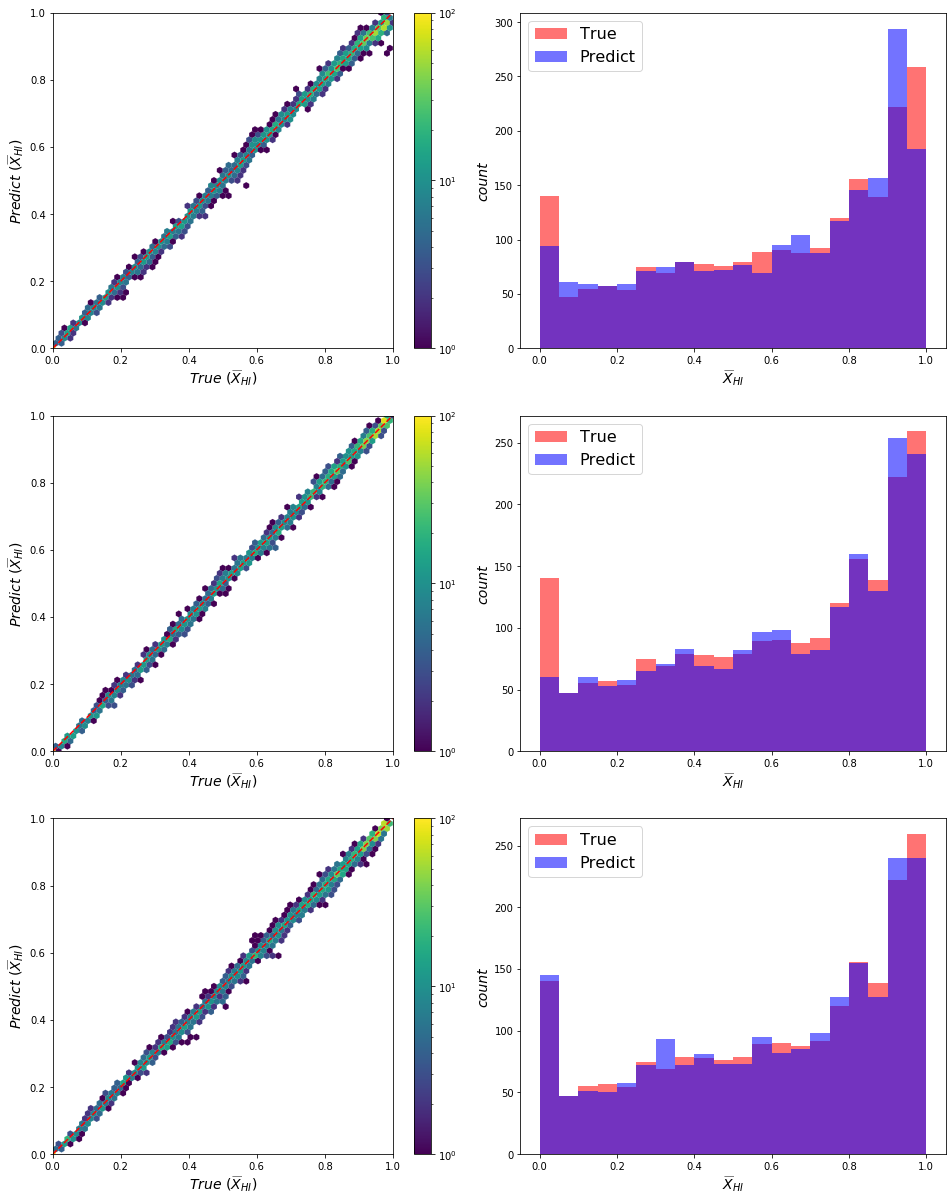

In [19]:
plt.clf()
fig, axs = plt.subplots(3,2, figsize=(16,21))

# BW0.2
hexaxs, histoaxs = axs[0][0], axs[0][1]
hexplot = hexaxs.hexbin(BS1_BW02_trueY, BS1_BW02_predY, bins='log', gridsize=58, extent=(0,1,0,1), cmap='viridis', mincnt=1, linewidths=(0.1,))
hexaxs.plot([0,1],[0,1], 'r--', lw=1.5)
hexaxs.set_xlabel("True $(\widebar{X}_{HI})$", style='italic',fontsize=14)
hexaxs.set_ylabel("Predict $(\widebar{X}_{HI})$", style='italic',fontsize=14)

histoaxs.hist(BS1_BW02_trueY, bins=binlist, color='Red',label='true', alpha=0.55)
histoaxs.hist(BS1_BW02_predY, bins=binlist, color='Blue', label='predict', alpha=0.55)
histoaxs.set_xlabel("$\widebar{X}_{HI}$", style='italic', fontsize=14)
histoaxs.set_ylabel("count", style='italic', fontsize=14)
histoaxs.legend(['True','Predict'], loc='upper left',prop={'size': 16})
plt.colorbar(hexplot,ax=hexaxs)
hexplot.set_clim(vmin=1, vmax=100)

# BW1
hexaxs, histoaxs = axs[1][0], axs[1][1]
hexplot = hexaxs.hexbin(BS1_BW1_trueY, BS1_BW1_predY, bins='log', gridsize=58, extent=(0,1,0,1), cmap='viridis', mincnt=1, linewidths=(0.1,))
hexaxs.plot([0,1],[0,1], 'r--', lw=1.5)
hexaxs.set_xlabel("True $(\widebar{X}_{HI})$", style='italic',fontsize=14)
hexaxs.set_ylabel("Predict $(\widebar{X}_{HI})$", style='italic',fontsize=14)

histoaxs.hist(BS1_BW1_trueY, bins=binlist, color='Red',label='true', alpha=0.55)
histoaxs.hist(BS1_BW1_predY, bins=binlist, color='Blue', label='predict', alpha=0.55)
histoaxs.set_xlabel("$\widebar{X}_{HI}$", style='italic', fontsize=14)
histoaxs.set_ylabel("count", style='italic', fontsize=14)
histoaxs.legend(['True','Predict'], loc='upper left',prop={'size': 16})
plt.colorbar(hexplot,ax=hexaxs)
hexplot.set_clim(vmin=1, vmax=100)

# BW2
hexaxs, histoaxs = axs[2][0], axs[2][1]
hexplot = hexaxs.hexbin(BS1_BW2_trueY, BS1_BW2_predY, bins='log', gridsize=58, extent=(0,1,0,1), cmap='viridis', mincnt=1, linewidths=(0.1,))
hexaxs.plot([0,1],[0,1], 'r--', lw=1.5)
hexaxs.set_xlabel("True $(\widebar{X}_{HI})$", style='italic',fontsize=14)
hexaxs.set_ylabel("Predict $(\widebar{X}_{HI})$", style='italic',fontsize=14)

histoaxs.hist(BS1_BW2_trueY, bins=binlist, color='Red',label='true', alpha=0.55)
histoaxs.hist(BS1_BW2_predY, bins=binlist, color='Blue', label='predict', alpha=0.55)
histoaxs.set_xlabel("$\widebar{X}_{HI}$", style='italic', fontsize=14)
histoaxs.set_ylabel("count", style='italic', fontsize=14)
histoaxs.legend(['True','Predict'], loc='upper left',prop={'size': 16})
plt.colorbar(hexplot,ax=hexaxs)
hexplot.set_clim(vmin=1, vmax=100)

fig.subplots_adjust(wspace=0.1)
plt.savefig("Thesis_BS3_histo&hexbin_dpi600tight.pdf", bbox_inches='tight', dpi=600)
plt.show()

In [187]:
model = load_model("/home/zoshs2/tf_gpu/Re/BS1_BW02_RGB/1th_CheckPointModels/77-0.0002.hdf5")

W1205 05:04:51.168206 140301636130624 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


In [188]:
test_data = np.load("/home/zoshs2/tf_gpu/Re/BS1_BW02_RGB/BS1_BW02_WG_RGB_TEST_DATASET.npy")
testY = test_data['xH']
testImageX = test_data['Img'] / 255.0

In [189]:
testOutput = model.predict(testImageX)#, batch_size=3)
testOutput = np.squeeze(testOutput, axis=1)

In [190]:
binlist = np.arange(0, 1.05, 0.05)

In [191]:
binlist

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

<Figure size 432x288 with 0 Axes>

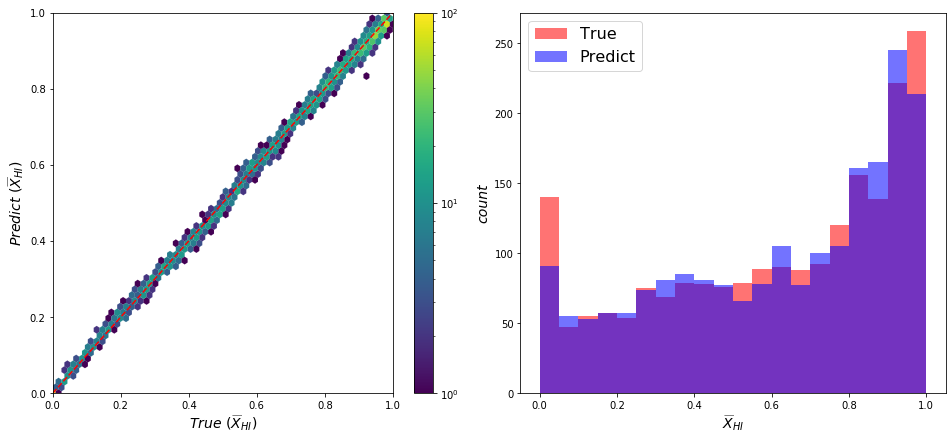

In [13]:
plt.clf()
fig, axs = plt.subplots(1,2, figsize=(16,7))
hexaxs, histoaxs = axs[0], axs[1]
hexplot = hexaxs.hexbin(testY, testOutput, bins='log', gridsize=58, extent=(0,1,0,1), cmap='viridis', mincnt=1, linewidths=(0.1,))
hexaxs.plot([0,1],[0,1], 'r--', lw=1.5)
hexaxs.set_xlabel("True $(\widebar{X}_{HI})$", style='italic',fontsize=14)
hexaxs.set_ylabel("Predict $(\widebar{X}_{HI})$", style='italic',fontsize=14)

histoaxs.hist(testY, bins=binlist, color='Red',label='true', alpha=0.55)
histoaxs.hist(testOutput, bins=binlist, color='Blue', label='predict', alpha=0.55)
histoaxs.set_xlabel("$\widebar{X}_{HI}$", style='italic', fontsize=14)
histoaxs.set_ylabel("count", style='italic', fontsize=14)
plt.legend(['True','Predict'], loc='upper left',prop={'size': 16})
plt.colorbar(hexplot,ax=hexaxs)
hexplot.set_clim(vmin=1, vmax=100)
fig.subplots_adjust(wspace=0.1)
plt.savefig("THESIS_BS1_BW02_HISto&hexbin_1000h.png", bbox_inches='tight')
plt.show()

In [90]:
test_data1 = np.load("/home/zoshs2/tf_gpu/Re/BS3_BW2_RGB/BS3_BW2_WG_RGB_TEST_DATASET.npy")
test_data2 = np.load("/home/zoshs2/tf_gpu/Re/BS3_BW1_RGB/BS3_BW1_WG_RGB_TEST_DATASET.npy")
test_data3 = np.load("/home/zoshs2/tf_gpu/Re/BS3_BW02_RGB/BS3_BW02_WG_RGB_TEST_DATASET.npy")
test_data4 = np.load("/home/zoshs2/tf_gpu/Re/BS2_BW2_RGB/BS2_BW2_WG_RGB_TEST_DATASET.npy")
test_data5 = np.load("/home/zoshs2/tf_gpu/Re/BS2_BW1_RGB/BS2_BW1_WG_RGB_TEST_DATASET.npy")
test_data6 = np.load("/home/zoshs2/tf_gpu/Re/BS2_BW02_RGB/BS2_BW02_WG_RGB_TEST_DATASET.npy")
test_data7 = np.load("/home/zoshs2/tf_gpu/Re/BS1_BW2_RGB/BS1_BW2_WG_RGB_TEST_DATASET.npy")
test_data8 = np.load("/home/zoshs2/tf_gpu/Re/BS1_BW1_RGB/BS1_BW1_WG_RGB_TEST_DATASET.npy")
test_data9 = np.load("/home/zoshs2/tf_gpu/Re/BS1_BW02_RGB/BS1_BW02_WG_RGB_TEST_DATASET.npy")

'''
testY = test_data['xH']
testImageX = test_data['Img'] / 255.0
'''

"\ntestY = test_data['xH']\ntestImageX = test_data['Img'] / 255.0\n"

In [91]:
testY1 = test_data1['xH']
testY2 = test_data2['xH']
testY3 = test_data3['xH']

testY4 = test_data4['xH']
testY5 = test_data5['xH']
testY6 = test_data6['xH']

testY7 = test_data7['xH']
testY8 = test_data8['xH']
testY9 = test_data9['xH']

In [107]:
np.std(testY6)

0.3086614514546581

## 딴거 시작

In [5]:
test_data = np.load("/home/zoshs2/tf_gpu/Re/BS1_BW02_RGB/BS1_BW02_WG_RGB_TEST_DATASET.npy")
testY = test_data['xH']
testImageX = test_data['Img'] / 255.0

In [11]:
model = load_model("/home/zoshs2/tf_gpu/Re/BS1_BW02_RGB/3th_CheckPointModels/92-0.0002.hdf5")

W1008 19:20:45.416287 140652009637696 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


In [12]:
testOutput = model.predict(testImageX)#, batch_size=3)
testOutput = np.squeeze(testOutput, axis=1)

In [13]:
binlist = np.arange(0, 1.05, 0.05)

In [14]:
binlist

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

<Figure size 432x288 with 0 Axes>

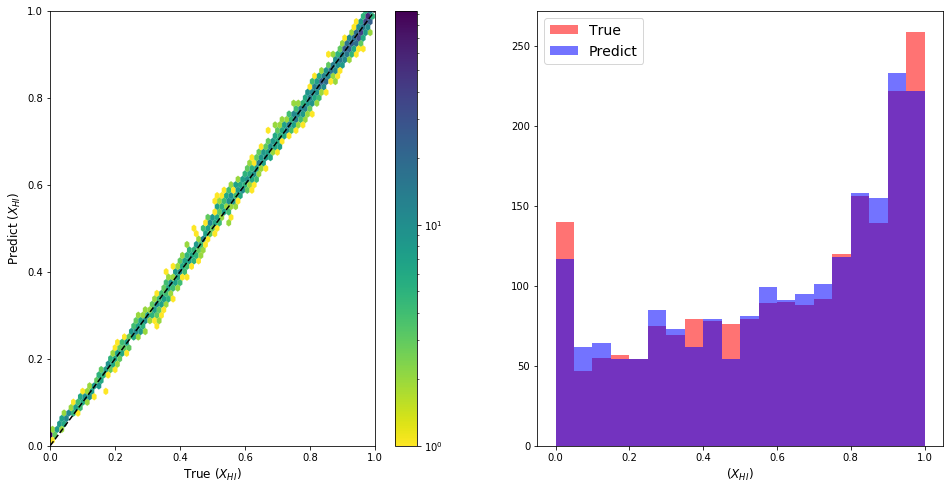

In [15]:
plt.clf()
fig, axs = plt.subplots(1,2, figsize=(16,8))
hexaxs, histoaxs = axs[0], axs[1]
hexplot = hexaxs.hexbin(testY, testOutput, gridsize=70, bins='log', extent=(0,1,0,1), cmap='viridis_r', mincnt=1, linewidths=(0.1,))
hexaxs.plot([0,1],[0,1], 'k--', lw=1.5)
hexaxs.set_xlabel("True $(X_{HI})$", fontsize=12)
hexaxs.set_ylabel("Predict $(X_{HI})$", fontsize=12)

histoaxs.hist(testY, bins=binlist, color='Red',label='true', alpha=0.55)
histoaxs.hist(testOutput, bins=binlist, color='Blue', label='predict', alpha=0.55)
histoaxs.set_xlabel("$(X_{HI})$", fontsize=12)
plt.legend(['True','Predict'], loc='upper left',prop={'size': 14})
plt.colorbar(hexplot,ax=hexaxs)
plt.savefig("POSTER_BS1_BW02_HISTO_1000h.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [16]:
test_data = np.load("/home/zoshs2/tf_gpu/Re/BS2_BW1_RGB/BS2_BW1_WG_RGB_TEST_DATASET.npy")
testY = test_data['xH']
testImageX = test_data['Img'] / 255.0

In [17]:
model = load_model("/home/zoshs2/tf_gpu/Re/BS2_BW1_RGB/0th_CheckPointModels/192-0.0002.hdf5")

In [18]:
testOutput = model.predict(testImageX)#, batch_size=3)
testOutput = np.squeeze(testOutput, axis=1)

In [19]:
binlist = np.arange(0, 1.05, 0.05)

In [20]:
binlist

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

<Figure size 432x288 with 0 Axes>

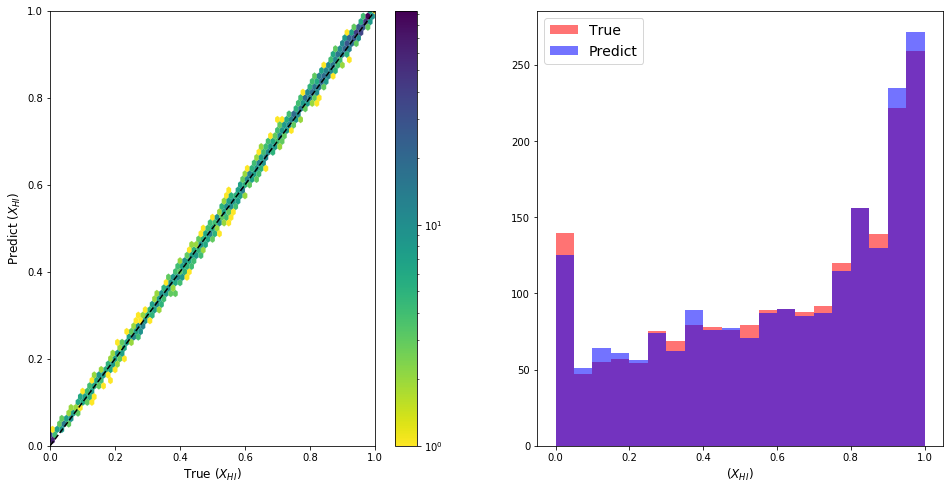

In [21]:
plt.clf()
fig, axs = plt.subplots(1,2, figsize=(16,8))
hexaxs, histoaxs = axs[0], axs[1]
hexplot = hexaxs.hexbin(testY, testOutput, gridsize=70, bins='log', extent=(0,1,0,1), cmap='viridis_r', mincnt=1, linewidths=(0.1,))
hexaxs.plot([0,1],[0,1], 'k--', lw=1.5)
hexaxs.set_xlabel("True $(X_{HI})$", fontsize=12)
hexaxs.set_ylabel("Predict $(X_{HI})$", fontsize=12)

histoaxs.hist(testY, bins=binlist, color='Red',label='true', alpha=0.55)
histoaxs.hist(testOutput, bins=binlist, color='Blue', label='predict', alpha=0.55)
histoaxs.set_xlabel("$(X_{HI})$", fontsize=12)
plt.legend(['True','Predict'], loc='upper left',prop={'size': 14})
plt.colorbar(hexplot,ax=hexaxs)
plt.savefig("POSTER_BS2_BW1_HISTO_1000h.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import argparse
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='valid', input_shape=(200,200,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(32, (3,3), padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(64, (3,3), padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Flatten())

## FC
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))

W1201 19:55:49.473182 140475062859584 deprecation.py:506] From /home/zoshs2/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 97, 97, 32)        0

In [6]:
test_set = np.load("./BS3_BW02_RGB/BS3_BW02_WG_RGB_TEST_DATASET.npy")

In [7]:
test_set.shape

(2064,)